# Table 1

## initial layout 

In [1]:
library(ggplot2)
library(bigrquery)
library(tidyverse)
library(ggplot2)
library(lubridate)
library(stats)
library(finalfit)
ProjectId = "yhcr-prd-bradfor-bia-core"

targetdb2 <- 'yhcr-prd-bradfor-bia-core.CB_FDM_DeathCertificates'
targetdb2 <-gsub(' ','',targetdb2)

targetdb3 <- 'yhcr-prd-bradfor-bia-core.CB_2172'
targetdb3 <- gsub(' ','',targetdb3)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


download data from connected bradford and create a master table by left joining the care_home_cohort table to the health characterstics

In [2]:
sql1 <- 
paste(
    'SELECT a.*, imd.imd, bm.bmi, htn.hypertension, bp.systolic_value , ck.ckd_diagnosis, ps.prev_stroke,dm.dm_diagnosis as diabetes_mellitus, af.af_diagnosis, chd.chd_diagnosis, hf.heart_failure as hf_diagnosis, ss.smoking_status, p.no_medication 
from ',targetdb3,'.care_home_cohort_v1 a 
left join ',targetdb3,'.cb_2172_efi2_value b on a.person_id = b.person_id 
left join ',targetdb3,'.efall_value e on a.person_id = e.person_id
left join ',targetdb3,'.cb_2172_polypharmacy p on a.person_id = p.person_id
left join ',targetdb3,'.temp_cb_2172_efi2_bmi bm on a.person_id = bm.person_id
left join ',targetdb3,'.temp_cb_2172_efi2 efi on a.person_id = efi.person_id
left join ',targetdb3,'.cb_2172_ckd_diagnosis ck on a.person_id = ck.person_id
left join ',targetdb3,'.cb_2172_previous_stroke ps on a.person_id = ps.person_id
left join ',targetdb3,'.cb_2172_ch_imd imd on a.person_id = imd.person_id 
left join ',targetdb3,'.cb_2172_dm_diagnosis dm on a.person_id = dm.person_id 
left join ',targetdb3,'.temp_cb_2172_af_diagnosis af on a.person_id = af.person_id
left join ',targetdb3,'.cb_2172_efi2_hf hf on a.person_id = hf.person_id
left join ',targetdb3,'.cb_2172_smoking_status ss on a.person_id = ss.person_id 
left join ',targetdb3,'.cb_2172_chd_diagnosis chd on a.person_id = chd.person_id 
left join ',targetdb3,'.cb_2172_hypertension_combined htn on a.person_id = htn.person_id
left join ',targetdb3,'.cb_2172_bp_post_admission bp on a.person_id = bp.person_id
;',sep="")

bp_tbl <-bq_project_query(ProjectId,sql1)
bp_data <- bq_table_download(bp_tbl)


First recode the binary variables as factors 

In [3]:
bp_data$hypertension.factor <- as.factor(bp_data$hypertension)

bp_data <- bp_data %>% select(-hypertension)

In [4]:
bp_data$service.factor <- as.factor(bp_data$admission_service)

bp_data <- bp_data %>% select(-admission_service)

In [5]:
bp_data$body_mass_index <- as.numeric(bp_data$bmi)

bp_data <- bp_data %>% select(-bmi)

In [6]:
bp_data$chronic_kidney_disease <- as.factor(bp_data$ckd_diagnosis)

bp_data <- bp_data %>% select(-ckd_diagnosis)


In [7]:
bp_data$ethnicity.factor <- as.factor(bp_data$ethnicity_source_value)
bp_data = bp_data %>% select(-ethnicity_source_value)

In [8]:
bp_data <- bp_data %>%
  mutate(
    ethnicity.final = fct_collapse(
      ethnicity.factor,
      "White" = c("White: English or Welsh or Scottish or Northern Irish or British - England and Wales ethnic category 2011 census", 
                  "White: Irish - England and Wales ethnic category 2011 census","White:Any other White background"),
    "Pakistani" = "Asian or Asian British: Pakistani - England and Wales ethnic category 2011 census","Missing" = "Unknown/Refuse to say",
    other_level = "DEPRECATED")
  )

In [9]:
bp_data$death_date <- as_date(bp_data$dod)
bp_data <- bp_data %>% select(-dod)

In [10]:
bp_data$previous_stroke <- as.factor(bp_data$prev_stroke)

bp_data <- bp_data %>% select(-prev_stroke)

In [11]:
bp_data$gender <- as.factor(bp_data$gender_source_value)

bp_data <- bp_data %>% select (-gender_source_value)

In [12]:
bp_data<- bp_data %>%  mutate(imd.factor = factor(bp_data$imd)) %>% mutate(imd.quintile =
           fct_collapse(imd.factor,"1" = c("1","2"),
                      "2"  = c("4","3"),
                       "3" = c("5","6"),
                         "4" = c("7","8"),
                         "5" = c("9","10")))

In [13]:
bp_data <-bp_data %>% 
  mutate(imd.quintile = imd.quintile %>%
           fct_relevel("1","2","3","4","5","missing")
         )

In [14]:
bp_data$diabetes.factor <- as.factor(bp_data$diabetes_mellitus)

bp_data <- bp_data %>% select (-diabetes_mellitus)

In [15]:
bp_data$af.factor <- as.factor(bp_data$af_diagnosis)

bp_data <- bp_data %>% select (-af_diagnosis)

In [16]:
bp_data$hf.factor<- as.factor(bp_data$hf_diagnosis)

bp_data <- bp_data %>% select (-hf_diagnosis)

In [17]:
bp_data$smoking.factor <- as.factor(bp_data$smoking_status)

bp_data <- bp_data %>%  select(-smoking_status)

code NA values for smoking status as missing factor level 

In [18]:
bp_data$smoking.factor <- fct_na_value_to_level(bp_data$smoking.factor,"missing")
           bp_data$smoking.factor %>% levels()                                 

[1] "current smoker" "ex-smoker"      "non-smoker"     "missing"

In [21]:
bp_data$chd.factor <- as.factor(bp_data$chd_diagnosis)

bp_data <- bp_data %>% select (-chd_diagnosis)

create factor variable where systolic blood pressure is present or absent 

In [22]:
bp_data <- bp_data %>% mutate(bp_present= case_when(is.na(systolic_value) ~ 'missing',systolic_value > 0 ~ 'yes'))

bp_data$bp_present.factor <- as.factor(bp_data$bp_present)

here we filter the care home cohort for those with a confirmed diagnosis of hypertension at the point of admission. all anaylsis from here on will be restricted to those with a diagnosis of hypertension

In [23]:
bp_data_filtered <- bp_data %>% filter(hypertension.factor == TRUE)

In [24]:
bp_data_filtered %>% group_by(bp_present) %>% summarise(n())

bp_present,n()
<chr>,<int>
missing,435
yes,1593


here I ran some explarotry statistical inference tests to determine whether the missingness of blood pressure values varied significantly between different characteristics 

In [25]:
bp_data_filtered %>% t.test(age_admission ~ bp_present.factor,data=.)


	Welch Two Sample t-test

data:  age_admission by bp_present.factor
t = 0.35799, df = 657.65, p-value = 0.7205
alternative hypothesis: true difference in means between group missing and group yes is not equal to 0
95 percent confidence interval:
 -0.6876766  0.9943286
sample estimates:
mean in group missing     mean in group yes 
             85.54253              85.38920 


In [26]:
#bp_data_filtered %>% t.test(efi2~ bp_present.factor,data=.)

created a new factor variable based on whether blood pressure target was above or below NICE guidelines

In [27]:


bp_data_filtered <- bp_data_filtered %>%  mutate(bp_target= if_else(systolic_value>=150 & age_admission >= 80| systolic_value>=140 & age_admission <80, "above","below", missing=NULL))

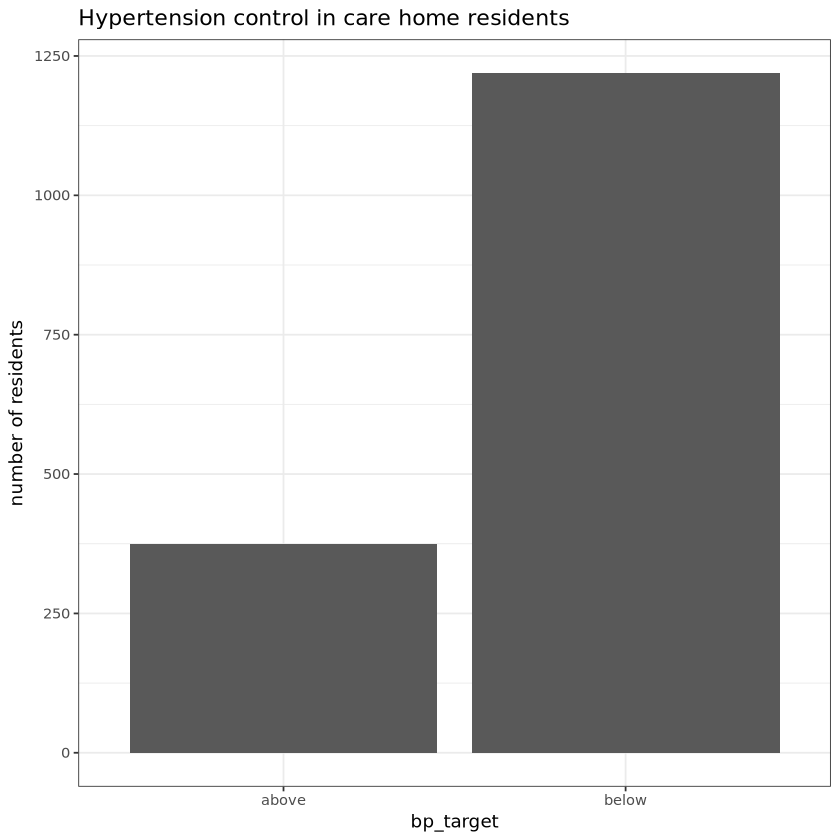

In [28]:
bp_data_filtered %>% filter(systolic_value >0) %>%  ggplot(aes(x= bp_target ))+geom_bar() + theme_bw()  + labs(y= "number of residents", title= "Hypertension control in care home residents")

In [29]:
library(finalfit)
bp_data_filtered %>%  
summary_factorlist(dependent= "bp_present.factor",
                   explanatory= c("hypertension.factor")
                   ) ,


label,levels,missing,yes
<chr>,<chr>,<chr>,<chr>
hypertension.factor,FALSE,0 (0.0),0 (0.0)
,TRUE,435 (100.0),1593 (100.0)


In [30]:
bp_data_filtered %>% 
  summary_factorlist(dependent = NULL, 
                     explanatory = 
                       c("imd.quintile", "previous_stroke")
  )

No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
imd.quintile,1,593 (29.3)
,2,334 (16.5)
,3,450 (22.2)
,4,255 (12.6)
,5,333 (16.4)
,missing,62 (3.1)
previous_stroke,no,1943 (95.8)
,yes,85 (4.2)


## Demographic and admission characteristics 

sql_death <- paste('
with a as (SELECT person_id,
dod,
tbl_NEC_Deaths,
reg_date,
rank() over(partition by person_id order by dod desc, reg_date desc) as rank_seq
from ',targetdb2,'.tbl_NEC_Deaths 
where person_id in (SELECT person_id from ',targetdb3,'.care_home_cohort_v1-0 where death_datetime is null)),

b as (
select
*,
row_number() over(partition by person_id order by person_id) as rank_seq_2
from a 
where rank_seq = 1)

select 
person_id, dod,reg_date from b 
where rank_seq_2 = 1 
order by person_id 
;',sep="")

tbl_death <-bq_project_query(ProjectId,sql_death)
ch_death<- bq_table_download(tbl_death)

print(ch_death)

In [ ]:
## 203 ghosts had death data, i assume that the remaining 94 are still alive, small number so happy to make this assumption. combined dod and reg_Date together to produce mater death date column which i will merge with the master cohort table. 

In [ ]:
ch_death <- ch_death %>% mutate(date_death = ifelse(is.na(dod), reg_date,dod))

In [ ]:
ch_death$date_death <- as_date(ch_death$date_death)

In [ ]:
## join death certificate tibble to the deathdate in the master cohort table 

In [ ]:
ch_death_filter <- ch_death %>% select(person_id,date_death)
bp_data <- left_join(bp_data,ch_death_filter,by='person_id')

In [ ]:
bp_data<- bp_data %>% mutate(dod = coalesce(bp_data$death_date,bp_data$date_death))%>% select(-death_date,-date_death)


In [ ]:
bp_data %>% filter(is.na(dod))

In [ ]:
bp_data <- bp_data %>% select(-life_exp)
head(bp_data)

In [ ]:
bp_data$first_episodestartdate <- as_date(bp_data$first_episodestartdate)


In [ ]:
bp_data<- bp_data %>% mutate(life_exp = interval(first_episodestartdate, dod) %/% months(1))

In [ ]:
bp_data %>% filter(!is.na(life_exp))%>% summary()

In [ ]:
threshold <- 12

data <- bp_data %>% filter(!is.na(bp_data$life_exp))
# Calculate the percentage of values below the threshold
death_1_year <- mean(data$life_exp < threshold) * 100

death_1_year

In [ ]:


bp_data %>% ggplot(aes(x=life_exp))+geom_histogram(binwidth = 3,col="black",fill="turquoise")+
geom_vline(xintercept = 10, color = "red", linetype = "dashed", linewidth = 1) +
labs(title = "Life Expectancy at admission",x="Life expectancy (months)",y="Frequency")+
theme_bw()+xlim(1.2,80) + 
annotate("text", x = 2, y = -5, label = "6 weeks")+annotate("text",x=28,y=300, label= "Median life expetancy: 11 months")

#ggsave("life_exp_hist.png", width = 10, height = 10)

### demographics table

In [32]:
bp_data_filtered %>% 
  mutate(
        age_admission = ff_label(age_admission, "Age at admission"),
      service.factor = ff_label(service.factor,"Service Type"),
      ethnicity.final = ff_label(ethnicity.final,"Ethnicity"),
      admission_length = ff_label(admission_length,"Admission length"),
      mortality = ff_label(mortality,"Lifespan"),
    ) %>% 
summary_factorlist(dependent= NULL, explanatory = c("age_admission","service.factor","gender","imd","ethnicity.final","admission_length","mortality") ) 

No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
Age at admission,Mean (SD),85.4 (7.6)
Service Type,Nursing,1140 (56.2)
,Residential,888 (43.8)
gender,F,1329 (65.5)
,M,699 (34.5)
imd,1,409 (20.2)
,10,180 (8.9)
,2,184 (9.1)
,3,218 (10.8)


## Cardiovascular Risk Factors 

In [33]:
bp_data_filtered %>% 

summary_factorlist(dependent= NULL, explanatory = c("age_admission","body_mass_index","af.factor","chronic_kidney_disease","hf.factor","chd.factor","diabetes.factor","smoking.factor","previous_stroke") )

No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
age_admission,Mean (SD),85.4 (7.6)
body_mass_index,Mean (SD),24.8 (6.8)
af.factor,no,1561 (77.3)
,yes,459 (22.7)
chronic_kidney_disease,yes,715 (100.0)
hf.factor,yes,331 (100.0)
chd.factor,yes,505 (100.0)
diabetes.factor,no,1453 (71.6)
,yes,575 (28.4)


## Electronic frailty index 2

In [ ]:
bp_data <- bp_data %>% 
  mutate(
    efi2.factor = 
      efi2 %>%
      cut(breaks = c(0,0.12,0.24,0.36,0.999), include.lowest= TRUE) %>% 
      fct_recode(
        "fit"      =  "[0,0.12]",
        "mild frailty" = "(0.12,0.24]",
        "moderate frailty" = "(0.24,0.36]",
        "severe frailty"  = "(0.36,0.999]"
      ) %>% 
      ff_label("Efi2 category"))



In [ ]:
bp_data %>% summary_factorlist(dependent = c("service.factor"),explanatory=c("efi2.factor"))

In [ ]:
efi2 <- bp_data %>% group_by(efi2.factor,service.factor) %>% summarise(freq=n())%>% mutate(percentage=(round(freq/sum(freq),3))*100)

efi2

In [ ]:
efi2%>%  ggplot(aes(fill=service.factor,x=efi2.factor,y= percentage))+ geom_col(fill='dark green') + theme_bw()+labs(x= "Electronic frailty index 2")+expand_limits(y=100)+geom_text(aes(label = percentage),vjust = 0)

In [ ]:
bp_data %>% 

summary_factorlist(dependent= NULL, explanatory = c("efi2","efall_value") )

In [ ]:
bp_data %>%  ggplot(aes(x= life_exp ))+ geom_histogram(bins=50) + theme_bw()

## Hypertension Prevalence

In [ ]:
is.na(bp_data$hypertension.factor)
#levels(bp_data$hypertension.factor)

In [ ]:
bp_data %>% summary_factorlist(dependent=NULL, explanatory = c("hypertension.factor"),na_to_prop=TRUE)

In [ ]:
 binom.test(2028,(766+2028), conf.level = 0.95)

In [ ]:
bp_data$bp_reading_factor <- as.factor(bp_data$bp_present)

# Antihypertensive medicaiton 

In [ ]:
sql_med<- paste('SELECT * from `CB_2172.cb_2172_antihypertensive_long_format` where person_id in (select person_id from ',targetdb3,'.care_home_cohort_v1) ;',sep="")

tbl_med <-bq_project_query(ProjectId,sql_med)

tbl_med <- bq_table_download(tbl_med)

tbl_med_f <- tbl_med %>% filter(early_death == 'false')
#still need to exclude those with a death
str(tbl_med)

In [ ]:
#switch time_status and medication binary variables to factor variables 
tbl_med_f$time_status.factor <- as.factor(tbl_med_f$time_status)

tbl_med_f <- tbl_med_f %>% select(-time_status)

### this section will produce a table of the type of antihypertensives prescribed and how this changes during admission in those with hypertension

In [ ]:
str(tbl_med_f)

In [ ]:
tbl_med_class <-tbl_med_f

In [ ]:
tbl_med_class$beta_blocker.factor <- as.factor(tbl_med_class$beta_blocker)

tbl_med <- tbl_med_class %>% select(-beta_blocker)

In [ ]:
tbl_med_class$calcium_channel_blocker.factor <- as.factor(tbl_med_class$calcium_channel_blocker)

tbl_med_class <- tbl_med_class %>% select(-calcium_channel_blocker)

In [ ]:
tbl_med_class$thiazide.factor <- as.factor(tbl_med_class$thiazide_type_diuretic)

tbl_med_class <- tbl_med_class %>% select(-thiazide_type_diuretic)

In [ ]:
tbl_med_class$angiotensin_receptor_blocker.factor <- as.factor(tbl_med_class$angiotensin_receptor_blocker)

tbl_med_class <- tbl_med_class %>% select(-angiotensin_receptor_blocker)

In [ ]:
tbl_med_class$ace_inhibitor.factor <- as.factor(tbl_med_class$ace_inhibitor)

tbl_med_class <- tbl_med_class %>% select(-ace_inhibitor)

In [ ]:
tbl_med_class$alpha_blocker.factor <- as.factor(tbl_med_class$alpha_blocker)

tbl_med_class <- tbl_med_class %>% select(-alpha_blocker)


In [ ]:
tbl_med_class$early_death.factor <- as.factor(tbl_med_class$early_death)

tbl_med_class <- tbl_med_class %>% select(-early_death)

In [ ]:
tbl_med$time_status.factor %>% levels()

In [ ]:
 tbl_med_class <- tbl_med_class %>% 
  mutate(time_status.factor = time_status.factor %>% 
           fct_relevel("pre_admission"))

tbl_med_class$time_status.factor %>% levels()

In [ ]:
tbl_med_class %>% summary_factorlist(dependent   ="time_status.factor" , 
                     explanatory = c("calcium_channel_blocker.factor", "beta_blocker.factor","ace_inhibitor.factor","angiotensin_receptor_blocker.factor","alpha_blocker.factor","thiazide.factor"))

### this next section will etermine the number of antihypertnesives prescribed for each inidiudal and how this changes ove rthe course of an admission 

In [ ]:
tbl_antihypertensive_class <- tbl_med_f %>%  filter(time_status.factor == 'admission')

In [ ]:
#convert medication data into long format

In [ ]:
tbl_med_long <- tbl_med_f %>% pivot_longer(beta_blocker:alpha_blocker,names_to = "antihypertensive",values_to= "prescribed")

In [ ]:
#recode antihypertenisve classess as factor vectors

In [ ]:
tbl_med_long$antihypertensive.factor <- as.factor(tbl_med_long$antihypertensive)
tbl_med_long<- tbl_med_long %>% select(-antihypertensive)

In [ ]:
head(tbl_med_long)

In [ ]:
#this was attempt at trying to do the group_by function in R< but didn't work so i just sent it back to bigquery and did it there because i know how to do it with SQL
#tbl_med_long_filtered <- tbl_med_long  %>%   group_by(person_id, tbl_med_long$time_status.factor)%>% summarise(antihypertensive.factor)

In [ ]:
names(tbl_med_long)[names(tbl_med_long) == "antihypertensive.factor"] <- "antihypertensive_type"
names(tbl_med_long)[names(tbl_med_long) == "time_status.factor"] <- "time_factor"

In [ ]:
mybq = bq_table(project='yhcr-prd-bradfor-bia-core', dataset='CB_2172', table='tbl_med_long_filtered')
bq_table_upload(x=mybq, values= tbl_med_long, create_disposition='CREATE_IF_NEEDED', 
             write_disposition='WRITE_TRUNCATE')

In [ ]:
sql4<- paste(
    'SELECT person_id, time_factor, avg(no_antihypertensive) as number_antihypertensive 
FROM `yhcr-prd-bradfor-bia-core.CB_2172.tbl_med_long_filtered` 
group by person_id, time_factor 
order by person_id, time_factor;'
             ,sep="")

tbl_antihtn <-bq_project_query(ProjectId,sql4)

tbl_antihtn <- bq_table_download(tbl_antihtn)



In [ ]:
 tbl_antihtn$number_antihypertensive.factor <- as.factor(tbl_antihtn$number_antihypertensive)
 tbl_antihtn$time.factor <- as.factor(tbl_antihtn$time_factor)

In [ ]:
 tbl_antihtn <- tbl_antihtn %>% 
  mutate(time.factor = time.factor %>% 
           fct_relevel("pre_admission"))

tbl_antihtn

In [ ]:
deprescribing_tibble <- tbl_antihtn %>% 
summary_factorlist(dependent   ="time.factor", 
                     explanatory = c("number_antihypertensive.factor"))

deprescribing_tibble

In [ ]:
#we will do the same anaylsis as above but remove thos we with co-indications for a beta-blocker, inlcuidng CHD, heaert failure, and atrial fibrillation. 
bp_data 
tbl_antihtn %>%  filter(person_id == 

In [ ]:
tbl_antihtn %>%  ggplot(aes(x= number_antihypertensive.factor)) + geom_bar(stat="count",width=0.7) + facet_grid(cols=vars(time.factor))+scale_fill_brewer(palette="Blues")+labs(x="Number of antihypertensives prescribed",title="Changes in antihypertensive prescriptions during care home admission")

In [ ]:
#tbl_med_long_filtered <- tbl_med_long  %>%   group_by(person_id,time_status.factor)%>% summarise(antihypertensive.factor)

In [ ]:
#this part will examine type of antihypertensives at the point of admission

## Blood pressure measurements

In [ ]:
# join the number of medications at admission to the master cohort dataframe in order to calculate number of people with BP measurements after admission by number of medication 

In [ ]:
no_medication <- tbl_antihtn %>% filter(time.factor == 'admission')

In [ ]:
master_tibble<-bp_data %>% inner_join(no_medication, by="person_id")
str(master_tibble)

In [ ]:
master_tibble %>% ggplot(aes(x=number_antihypertensive.factor,fill=bp_present))+geom_bar(position="fill")+labs(x="numer of antihypertensives",y="proportion with bp present")

In [ ]:
master_tibble %>% ggplot(aes(x=number_antihypertensive.factor,fill=bp_target))+geom_bar(position="fill")+labs(x="number of antihypertensives",y="proportion with bp present")

In [ ]:
master_tibble %>% ggplot(aes(x=efi2.factor,fill=bp_target))+geom_bar(position="fill")+labs(y="proportion with bp present")